In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from load_utils import *

In [6]:
d = load_diffs()
df_events, df_blocked_user_text = load_block_events_and_users()

# Group Comparisons

Lets break down data into different groups and compare the mean aggression and attack scores

In [95]:
def mpg(df, score, cols):
    """
    return row with max score in each group of cols values
    """
    return df.sort(score, ascending=False).groupby(cols, as_index=False).first()

def compare_groups(df, x, mpu = False, order = None, hue = None, plot = True, table = True):
    agg = 'pred_aggression_score'
    rec = 'pred_recipient_score'
    
    if table:
        if hue:
            print(df.groupby([x, hue])[agg, rec].mean())
        else:
            print(df.groupby([x])[agg, rec].mean())
    
    if plot:
        
        fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize = (12,6))

        if mpu:
            cols = ['user_text', x]
            plt.figure()
            sns.pointplot(x=x, y= agg, data=mpg(df, agg, cols) , order = order, hue = hue, ax = ax1)
            plt.figure()
            sns.pointplot(x=x, y= rec, data=mpg(df, rec, cols) , order = order, hue = hue, ax = ax2)
        else:
            
            ax = sns.pointplot(x=x, y= agg, data=df, order = order, hue = hue, ax = ax1)
            plt.figure()
            ax = sns.pointplot(x=x, y= rec, data=df, order = order, hue = hue, ax = ax2)
            

### Q: How do comments made by registered and anonymous authors compare?

             pred_aggression_score  pred_recipient_score
author_anon                                             
False                    -0.055197              0.032946
True                      0.080100              0.096603


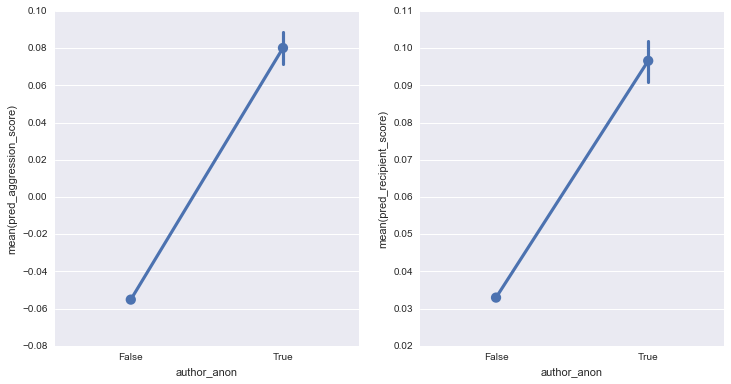

In [101]:
o = (False, True)
x = 'author_anon'
compare_groups(d['sample'][:100000], x, order = o)

In [119]:
#x = 'author_anon'
#plot_scores(df_no_admin_2015, x, order = o)

### Q: How do comments received by registered and anonymous authors compare?

                pred_aggression_score  pred_recipient_score
recipient_anon                                             
False                       -0.057084              0.034873
True                        -0.034437              0.030891


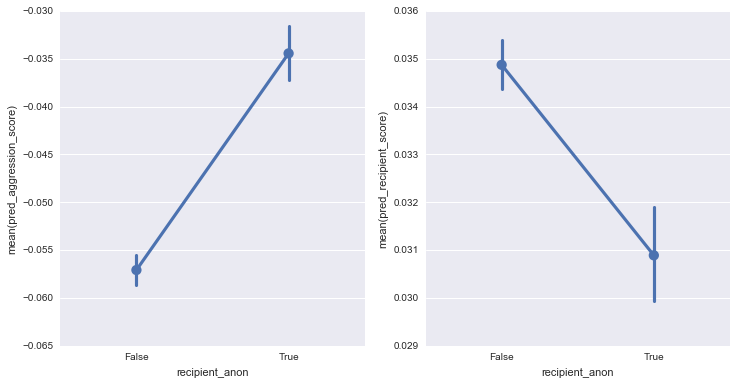

In [100]:
# don't count posts to own article
x = 'recipient_anon'
compare_groups(d['sample'][:100000].query('not own_page'), x, order = o)

In [59]:
#x = 'recipient_anon'
#plot_scores(df_no_admin_2015, x, order = o)

### Q: How do authors write differently on their own page than on other pages?

          pred_aggression_score  pred_recipient_score
own_page                                             
False                 -0.054011              0.034333
True                  -0.030057              0.041521


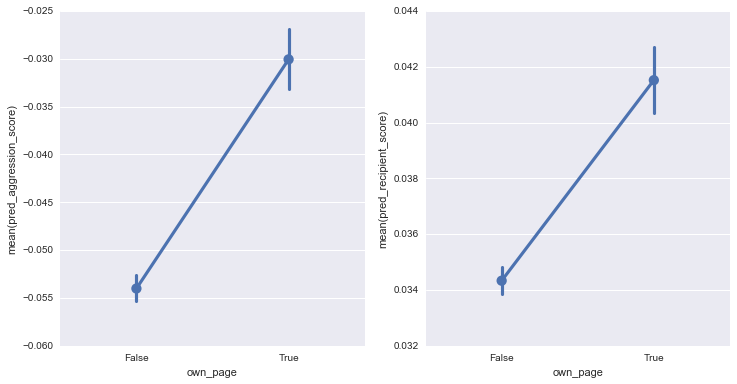

In [103]:
x = 'own_page'
o = (False, True)
compare_groups(d['sample'][:100000], x, order = o)

                      pred_aggression_score  pred_recipient_score
own_page author_anon                                             
False    False                    -0.059323              0.031784
         True                      0.064165              0.091044
True     False                    -0.038867              0.037544
         True                      0.132372              0.114837


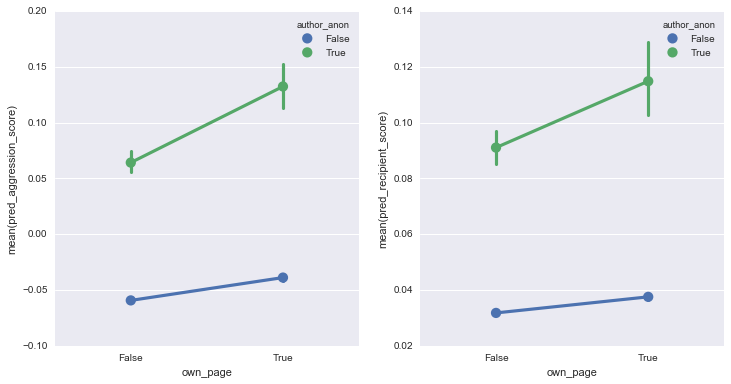

In [104]:
x = 'own_page'
compare_groups(d['sample'][:100000], x, order = o, hue = 'author_anon')

## Time

### Q: Has the amount of aggressiveness and attacks changed year over year?

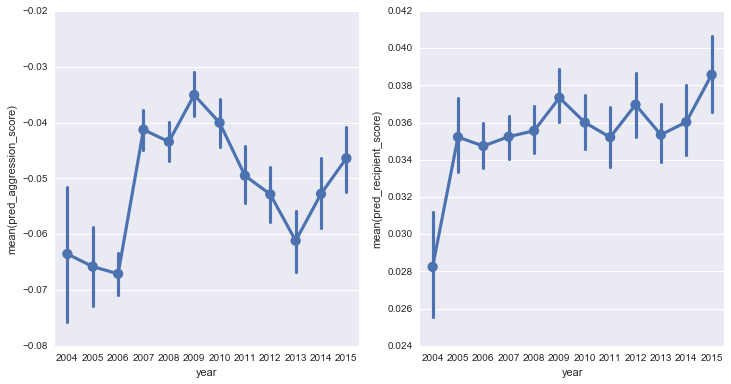

In [105]:
df_span = d['sample'][:100000].query('year > 2003 & year < 2016')
x = 'year'
o = range(2004, 2016)
compare_groups(df_span, x, order = o, table = False)

### Q: Is there a seasonal effect?

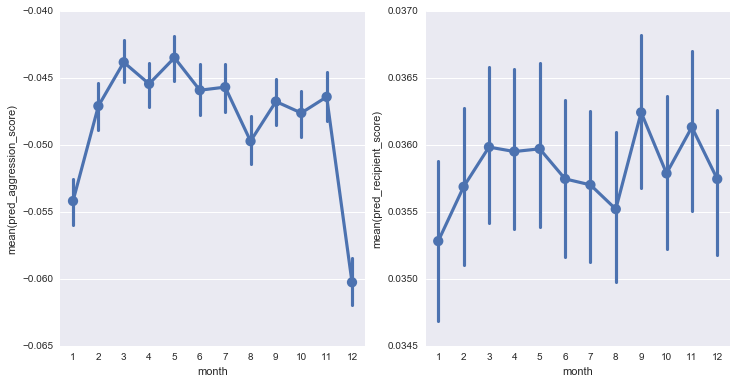

In [109]:
x = 'month'
o = range(1, 13)
compare_groups(d['sample'], x, order = o, table = False)

### Q: Is there an hour of day effect?

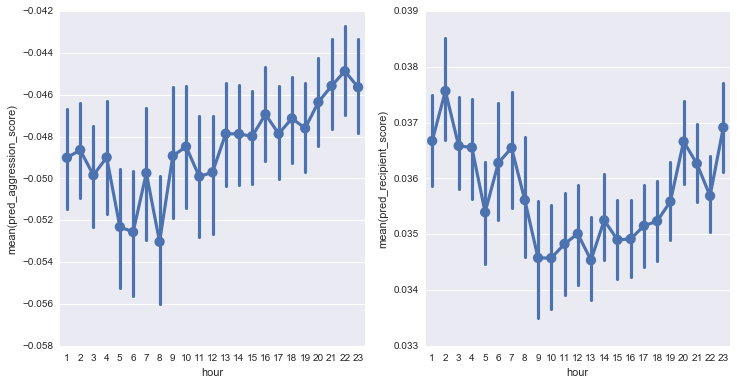

In [108]:
x = 'hour'
o  = range(1, 24)
compare_groups(d['sample'], x, order = o, table = False)

## Gender

In [150]:
from db_utils import query_analytics_store

In [110]:
## Annotate users by gender
query = """
SELECT
    user_id,
    user_name as user_text,
    up_value as gender
FROM
    enwiki.user_properties p,
    enwiki.user u
WHERE 
    p.up_user = u.user_id
    AND up_property = 'gender'
"""
#d_gender = query_analytics_store(query, {})
#d_gender.to_csv('genders.tsv', sep = '\t', index = False)
d_gender = pd.read_csv('genders.tsv', sep = '\t')

In [112]:
def remap_author_gender(r):
    if r['gender'] == 'male':
        return 'male'
    elif r['gender'] == 'female':
        return 'female'
    elif r['author_anon']:
        return 'unknown:anon'
    else:
        return 'unknown: registered'
    
    
df_no_admin_gender = d['2015'].\
                     merge(d_gender, how = 'left', on = 'user_id', suffixes = ('', '_x')).\
                     assign(author_gender = lambda x: x.apply(remap_author_gender, axis = 1)).\
                     drop(['gender', 'user_text_x'], axis=1)

In [113]:
def remap_recipient_gender(r):
    if r['gender'] == 'male':
        return 'male'
    elif r['gender'] == 'female':
        return 'female'
    elif r['recipient_anon']:
        return 'unknown:anon'
    else:
        return 'unknown: registered'
    
df_no_admin_gender = df_no_admin_gender.\
                     merge(d_gender, how = 'left', left_on = 'page_title', right_on = 'user_text', suffixes = ('', '_x')).\
                     assign(recipient_gender = lambda x: x.apply(remap_recipient_gender, axis = 1)).\
                     drop(['gender', 'user_text_x', 'user_id_x'], axis=1)

In [114]:
df_no_admin_gender.author_gender.value_counts()

unknown: registered    524267
male                   351570
unknown:anon            56543
female                  48485
Name: author_gender, dtype: int64

In [115]:
df_no_admin_gender.recipient_gender.value_counts()

unknown: registered    583758
male                   304166
unknown:anon            48223
female                  44718
Name: recipient_gender, dtype: int64

### Q: What is the effect of the author's gender?

                     pred_aggression_score  pred_recipient_score
author_gender                                                   
female                           -0.098558              0.033322
male                             -0.076705              0.030826
unknown: registered              -0.057319              0.037918
unknown:anon                      0.159108              0.077585


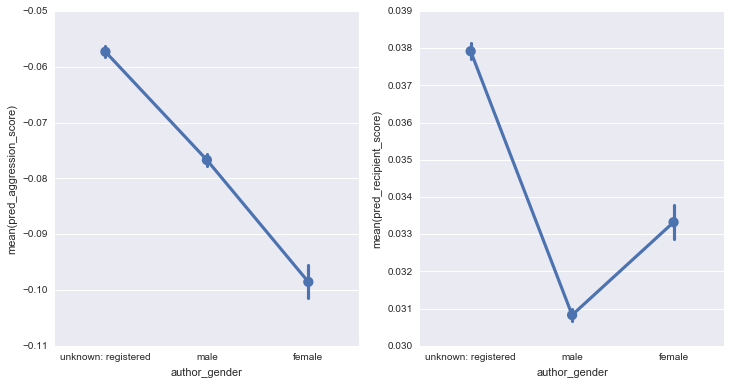

In [72]:
o = ('unknown: registered', 'male', 'female')
x = 'author_gender'
compare_groups(df_no_admin_gender, x, order = o)

### Q: What is the effect of the recipient's gender?

                     pred_aggression_score  pred_recipient_score
recipient_gender                                                
female                           -0.069668              0.037555
male                             -0.052091              0.039116
unknown: registered              -0.054627              0.036913
unknown:anon                     -0.006574              0.040416


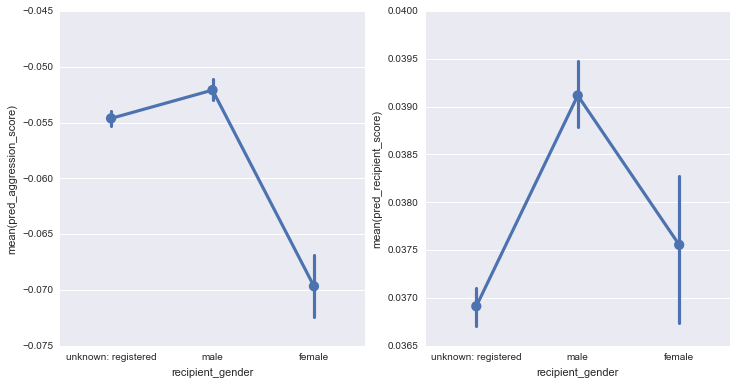

In [116]:
o = ('unknown: registered', 'male', 'female')
x = 'recipient_gender'
compare_groups(df_no_admin_gender.query('not own_page'), x, order= o)

### Q: How does the effect change when you interact author and recipient gender?

                                         pred_aggression_score  \
recipient_gender    author_gender                                
female              female                           -0.105718   
                    male                             -0.066547   
                    unknown: registered              -0.077708   
male                female                           -0.088438   
                    male                             -0.062105   
                    unknown: registered              -0.056973   
unknown: registered female                           -0.075662   
                    male                             -0.048264   
                    unknown: registered              -0.066904   
unknown:anon        female                           -0.029653   
                    male                             -0.015713   
                    unknown: registered              -0.009921   

                                         pred_recipient_score  
recipient_g

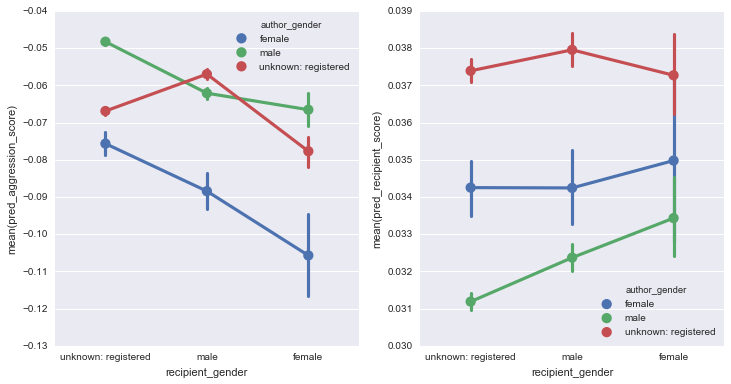

In [117]:
o = ('unknown: registered', 'male', 'female')
x = 'recipient_gender'
compare_groups(df_no_admin_gender.query("not own_page and author_gender != 'unknown:anon'"), x, order = o, hue = 'author_gender')